In [1]:
# IMPORT RELEVANT MODULES

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import torch
import os
from botorch.test_functions.multi_objective import BraninCurrin
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.utils.transforms import unnormalize
from botorch.utils.sampling import draw_sobol_samples
from botorch.optim.optimize import optimize_acqf, optimize_acqf_list
from botorch.acquisition.objective import GenericMCObjective
from botorch.utils.multi_objective.scalarization import get_chebyshev_scalarization
from botorch.utils.multi_objective.box_decompositions.non_dominated import NondominatedPartitioning
from botorch.acquisition.multi_objective.monte_carlo import qExpectedHypervolumeImprovement
from botorch.utils.sampling import sample_simplex
from botorch import fit_gpytorch_model
from botorch.acquisition.monte_carlo import qExpectedImprovement, qNoisyExpectedImprovement
from botorch.sampling.samplers import SobolQMCNormalSampler
from botorch.exceptions import BadInitialCandidatesWarning
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.utils.multi_objective.hypervolume import Hypervolume

tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}

# Global Variables

BATCH_SIZE = 1 # Number of design parameter points to query at next iteration
NUM_RESTARTS = 10 # Used for the acquisition function number of restarts in optimization
RAW_SAMPLES = 1024 # Initial restart location candidates
N_ITERATIONS = 35 # Number of optimization iterations
MC_SAMPLES = 512 # Number of samples to approximate acquisition function
N_INITIAL = 5
SEED = 2 # Seed to initialize the initial samples obtained

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
problem_dim = 2
num_objs = 2
# # Design parameter bounds
# problem_bounds = torch.zeros(2, problem_dim, **tkwargs)
# # initialize the problem bounds
# # for i in range(4):
# #     problem_bounds[0][i] = parameters_info[i][0]
# #     problem_bounds[1][i] = parameters_info[i][1]
# problem_bounds[1] = 1


problem_bounds = torch.tensor([[0., 0.], [1., 1.]])

# Reference point in objective function space
ref_point = torch.tensor([-1. for _ in range(num_objs)])
print(ref_point)

def unnormalise_parameters(x_tensor):
    # BINH AND KORN FUNCTION BOUNDS
    # x_bounds = torch.tensor([[0., 0.], [5., 5.]])

    # TEST MAX AND MIN OPTIMISATION TOGETHER
    # x_bounds = torch.tensor([[0., 0.], [5., 5.]])

    # OPTIMIZE ANYTHING (HOLIDAY EXAMPLE)
    x_bounds = torch.tensor([[500., 3.], [3000., 14.]])

    train_x_actual_1 = x_tensor[0][0]*(x_bounds[1][0] - x_bounds[0][0]) + x_bounds[0][0]
    train_x_actual_2 = x_tensor[0][1]*(x_bounds[1][1] - x_bounds[0][1]) + x_bounds[0][1]
    x_actual = torch.tensor([[train_x_actual_1, train_x_actual_2]])

    return x_actual

def objective_function(x_tensor):
    # BINH AND KORN FUNCTION
    # objectives_min_max = ["minimise", "minimise"]
    # objectives_bounds = torch.tensor([[0., 0.], [200., 50.]])
    # obj_1 = 4*(x_tensor[0][0])**2 + 4*(x_tensor[0][1])**2
    # obj_2 = (x_tensor[0][0]-5)**2 + (x_tensor[0][1]-5)**2

    # TEST MAX AND MIN OPTIMISATION TOGETHER
    # objectives_min_max = ["maximise", "minimise"]
    # objectives_bounds = torch.tensor([[0., 0.], [50., 18.]])
    # obj_1 = (x_tensor[0][0])**2 + (x_tensor[0][1])**2
    # obj_2 = (x_tensor[0][0]-2)**2 + (x_tensor[0][1]-2)**2

    # OPTIMIZE ANYTHING (HOLIDAY EXAMPLE)
    objectives_min_max = ["minimise", "maximise"]
    objectives_bounds = torch.tensor([[100., 0.], [1000., 100.]]) # Cost and Satisfaction
    while True:
        obj_1 = input("Enter Cost ($): ") # Bounds [100, 1000]
        try:
            obj_1 = float(obj_1)
            if (obj_1 >= objectives_bounds[0][0] and obj_1 <= objectives_bounds[1][0]):
                break
            else:
                raise ValueError
        except ValueError:
            print("Error. Please enter a valid measurement, within the objective bounds (100 - 1000).")
    while True:
        obj_2 = input("Enter Satisfaction (%): ") # Bounds [0, 100]
        try:
            obj_2 = float(obj_2)
            if (obj_2 >= objectives_bounds[0][1] and obj_2 <= objectives_bounds[1][1]):
                break
            else:
                raise ValueError
        except ValueError:
            print("Error. Please enter a valid measurement, within the objective bounds (0 - 100).")

    obj_tensor_actual = torch.tensor([[obj_1, obj_2]], dtype=torch.float64)

    # NORMALISE OBJECTIVES
    obj_tensor_norm = torch.zeros(obj_tensor_actual.size(), dtype=torch.float64)
    for i in range (obj_tensor_actual.size()[1]):
      if (objectives_min_max[i] == "minimise"): # MINIMISE (SMALLER VALUES CLOSER TO 1)
        obj_tensor_norm[0][i] = -2*((obj_tensor_actual[0][i] - objectives_bounds[0][i])/(objectives_bounds[1][i] - objectives_bounds[0][i])) + 1
      elif (objectives_min_max[i] == "maximise"): # MAXIMISE (LARGER VALUES CLOSER TO -1)
        obj_tensor_norm[0][i] =  2*((obj_tensor_actual[0][i] - objectives_bounds[0][i])/(objectives_bounds[1][i] - objectives_bounds[0][i])) - 1

    return obj_tensor_norm, obj_tensor_actual

def generate_initial_data(n_samples=1):
    # generate training data
    train_x = draw_sobol_samples(
        bounds=problem_bounds, n=1, q=n_samples, seed=torch.randint(1000000, (1,)).item()
    ).squeeze(0)
    train_x = train_x.type(torch.DoubleTensor)
    train_x_actual = unnormalise_parameters(train_x)
    print("Initial solution: ", train_x_actual)
    while (checkForbiddenRegions(bad_solutions, train_x_actual) == False):
        print("Proposed solution in forbidden region")
        train_x = draw_sobol_samples(
            bounds=problem_bounds, n=1, q=n_samples, seed=torch.randint(1000000, (1,)).item()
        ).squeeze(0)
        train_x = train_x.type(torch.DoubleTensor)
        train_x_actual = unnormalise_parameters(train_x)
        print("Initial solution: ", train_x_actual)
    
    train_obj_actual, train_obj = objective_function(train_x_actual)
    return train_x, train_x_actual, train_obj, train_obj_actual

def checkForbiddenRegions(bad_solutions, proposed_solution):
  for i in range(len(bad_solutions)):
    # print(proposed_solution[0][1])
    # print(bad_solutions[i][0])
    if (proposed_solution[0][0] < bad_solutions[i][0]*1.05 and proposed_solution[0][0] > bad_solutions[i][0]*0.95 and proposed_solution[0][1] < bad_solutions[i][1]*1.05 and proposed_solution[0][1] > bad_solutions[i][1]*0.95):
      return False
  return True

bad_solutions = [[500, 3], [3000, 14], [3000, 3], [500, 14]]
train_x, train_x_actual, train_obj, train_obj_actual = generate_initial_data()

tensor([-1., -1.])
Initial solution:  tensor([[1881.7063,   11.0942]], dtype=torch.float64)


In [4]:
def initialize_model(train_x, train_obj):
    # define models for objective and constraint
    model = SingleTaskGP(train_x, train_obj, outcome_transform=Standardize(m=train_obj.shape[-1]))
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    return mll, model

In [3]:
def optimize_qehvi(model, train_obj, sampler):
    """Optimizes the qEHVI acquisition function, and returns a new candidate and observation."""
    # partition non-dominated space into disjoint rectangles
    partitioning = NondominatedPartitioning(ref_point=ref_point, Y=train_obj)
    acq_func = qExpectedHypervolumeImprovement(
        model=model,
        ref_point=ref_point.tolist(),  # use known reference point
        partitioning=partitioning,
        sampler=sampler,
    )
    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=problem_bounds,
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200, "nonnegative": True},
        sequential=True,
    )
    # observe new values
    new_x =  unnormalize(candidates.detach(), bounds=problem_bounds)
    new_x_actual = unnormalise_parameters(new_x)
    print("Next solution: ", new_x_actual)

    if (checkForbiddenRegions(bad_solutions, new_x_actual) == False):
        print("Solution proposed within forbidden region")
        # new_x =  unnormalize(candidates.detach(), bounds=problem_bounds)
        # new_x_actual = unnormalise_parameters(new_x)
        new_x, new_x_actual, new_obj, new_obj_actual = generate_initial_data()
        print("Next solution: ", new_x_actual)
    else:
        new_obj, new_obj_actual = objective_function(new_x_actual)

    return new_x, new_x_actual, new_obj, new_obj_actual

In [5]:
def mobo_execute(seed, iterations, initial_samples):
    torch.manual_seed(seed)

    hv = Hypervolume(ref_point=ref_point)
    # Hypervolumes
    hvs_qehvi = []

    # Initial Samples
    # train_x_qehvi, train_obj_qehvi = load_data()
    train_x_qehvi, train_x_actual_qehvi, train_obj_qehvi, train_obj_actual_qehvi = generate_initial_data()

    # Initialize GP models
    mll_qehvi, model_qehvi = initialize_model(train_x_qehvi, train_obj_qehvi)

    # Compute Pareto front and hypervolume
    pareto_mask = is_non_dominated(train_obj_qehvi)
    pareto_y = train_obj_qehvi[pareto_mask]
    volume = hv.compute(pareto_y)
    hvs_qehvi.append(volume)
    # save_xy(train_x_qehvi, train_obj_qehvi, hvs_qehvi)

    # Go through the iterations

    for iteration in range(1, iterations + 1):
        print("Iteration: " + str(iteration))
        # Fit Models
        fit_gpytorch_model(mll_qehvi)

        # Define qEI acquisition modules using QMC sampler
        qehvi_sampler = SobolQMCNormalSampler(num_samples=MC_SAMPLES)

        # Optimize acquisition functions and get new observations
        new_x_qehvi, new_x_actual_qehvi, new_obj_qehvi, new_obj_actual_qehvi = optimize_qehvi(model_qehvi, train_obj_qehvi, qehvi_sampler)
        # new_obj_qehvi = objective_function(new_x_qehvi[0])

        # Update training points
        train_x_qehvi = torch.cat([train_x_qehvi, new_x_qehvi])
        train_x_actual_qehvi = torch.cat([train_x_actual_qehvi, new_x_actual_qehvi])
        train_obj_qehvi = torch.cat([train_obj_qehvi, new_obj_qehvi])
        train_obj_actual_qehvi = torch.cat([train_obj_actual_qehvi, new_obj_actual_qehvi])

        # Compute hypervolumes
        pareto_mask = is_non_dominated(train_obj_qehvi)
        pareto_y = train_obj_qehvi[pareto_mask]
        volume = hv.compute(pareto_y)
        hvs_qehvi.append(volume)

        # save_xy(train_x_qehvi, train_obj_qehvi, hvs_qehvi)
        print("training x actual", train_x_actual_qehvi[-1])
        print("training x", train_x_qehvi[-1])
        print("training obj actual", train_obj_actual_qehvi[-1])
        print("training obj", train_obj_qehvi[-1])
        print("mask", pareto_mask)
        print("pareto y", pareto_y[-1])
        print("volume", volume)
        print("\n")
        mll_qehvi, model_qehvi = initialize_model(train_x_qehvi, train_obj_qehvi)

    return hvs_qehvi, train_x_qehvi, train_x_actual_qehvi, train_obj_qehvi, train_obj_actual_qehvi

hvs_qehvi, train_x_qehvi, train_x_actual_qehvi, train_obj_qehvi, train_obj_actual_qehvi = mobo_execute(SEED, 10, 1)

Initial solution:  tensor([[2026.5149,    8.6132]], dtype=torch.float64)
Iteration: 1
Next solution:  tensor([[500.,   3.]])
Solution proposed within forbidden region
Initial solution:  tensor([[2571.7861,    8.1740]], dtype=torch.float64)
Next solution:  tensor([[2571.7861,    8.1740]], dtype=torch.float64)
training x actual tensor([2571.7861,    8.1740], dtype=torch.float64)
training x tensor([0.8287, 0.4704], dtype=torch.float64)
training obj actual tensor([-0.3333,  0.2000], dtype=torch.float64)
training obj tensor([700.,  60.], dtype=torch.float64)
mask tensor([False,  True])
pareto y tensor([700.,  60.], dtype=torch.float64)
volume 42761.0


Iteration: 2
Next solution:  tensor([[3000.0000,    5.6172]])
Error. Please enter a valid measurement, within the objective bounds (100 - 1000).
training x actual tensor([3000.0000,    5.6172], dtype=torch.float64)
training x tensor([1.0000, 0.2379], dtype=torch.float64)
training obj actual tensor([750.,  45.], dtype=torch.float64)
training o

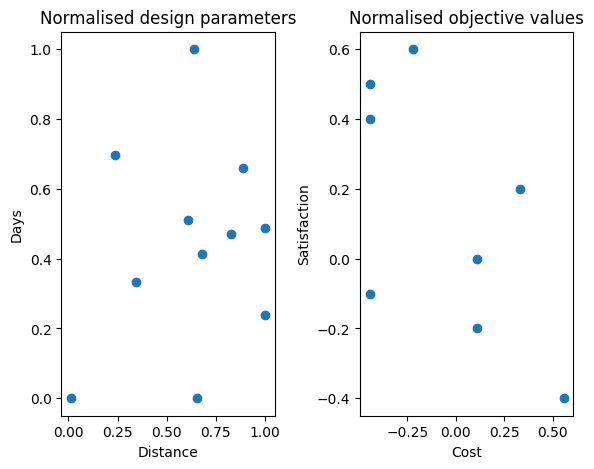

In [9]:
%matplotlib inline

plt.subplot(121)
plt.title("Normalised design parameters")
plt.scatter(train_x_qehvi.T[0], train_x_qehvi.T[1])
plt.xlabel("Distance")
plt.ylabel("Days")

plt.subplot(122)
plt.title('Normalised objective values')
plt.scatter(train_obj_qehvi.T[0][2:-1], train_obj_qehvi.T[1][2:-1])
plt.xlabel('Cost')
plt.ylabel('Satisfaction')

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

plt.show()